Objective

The goal of this project is to predict the directional movement (UP / DOWN) of a stock’s closing price over the next 15 trading days using historical market data and machine-learning models.

Key Assumptions

Markets exhibit short- to medium-term momentum and mean-reversion patterns that can be learned from historical prices.

Past price-derived features (returns, volatility, momentum etc) contain predictive signal.

Trades are executed without transaction costs, slippage, or liquidity constraints (simplified backtest).

The model predicts direction only, not magnitude.

Each ticker is modeled independently (no cross-asset learning).

In [ ]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay
)


project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_data, add_returns
from src.features import (
    add_lagged_returns,
    add_moving_averages,
    add_volatility,
    add_momentum,
    add_calendar_features
)
from src.target import create_target
from src.backtest import backtest_strategy
from src.metrics import sharpe_ratio, max_drawdown


Design Rationale

Separation of concerns
Raw data, engineered features, and results are strictly isolated

Reproducibility
Intermediate artifacts are saved at each stage

Extensibility
Additional models (e.g., XGBoost, LSTM) can use separate result folders

Production readiness
Mirrors real-world ML pipeline organization

In [ ]:
BASE_DATA_DIR = "../data"

RAW_DIR = f"{BASE_DATA_DIR}/raw"
PROCESSED_DIR = f"{BASE_DATA_DIR}/processed"
SPLIT_DIR = f"{BASE_DATA_DIR}/splits"

# DIFFERENT RESULTS DIRECTORY FOR LOGISTIC
LOGISTIC_RESULTS_DIR = f"{BASE_DATA_DIR}/results_logistic"

for d in [RAW_DIR, PROCESSED_DIR, SPLIT_DIR, LOGISTIC_RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("All directories ready")


All directories ready ✅


# Data Source
  Daily OHLCV data for:
    RELIANCE.NS
    HDFCBANK.NS
    INFY.NS

# Initial Exploration

    Converted raw prices into daily returns
    Checked for:
        Missing values
        Outliers in returns
        Class imbalance in target variable


In [4]:
TICKERS = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

HORIZON = 15
TRAIN_RATIO = 0.8
N_SPLITS = 5


# Per-Ticker Data Processing Pipeline
Each stock ticker is processed independently through a standardized pipeline to ensure consistency, reproducibility, and leakage-free feature generation.

# High-Level Workflow

    For every ticker in TICKERS, the pipeline performs:
    Load raw OHLCV data
    Compute daily returns
    Save raw data snapshot
    Generate engineered features
    Create prediction target
    Clean and align dataset
    Persist final feature matrix

# features 
    Lagged Returns: Past returns over multiple horizons capture short-term momentum and mean-reversion behavior.

    Moving Averages: SMAs and price-to-SMA ratios quantify trend direction and strength.

    Volatility: Rolling return standard deviation measures market risk and regime changes.

    Momentum: Rate-of-change features capture the persistence of price trends. 

    and many more....    

In [5]:
for ticker in TICKERS:
    print(f"\nProcessing {ticker}")

    df = load_data(ticker)
    df = add_returns(df)

    df.to_csv(f"{RAW_DIR}/{ticker}.csv", index=False)

    df = add_lagged_returns(df)
    df = add_moving_averages(df)
    df = add_volatility(df)
    df = add_momentum(df)
    df = add_calendar_features(df)

    df = create_target(df, horizon=HORIZON)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.to_csv(f"{PROCESSED_DIR}/{ticker}_features.csv", index=False)



Processing RELIANCE.NS

Processing HDFCBANK.NS

Processing INFY.NS


# Model Training, Validation & Backtesting (Logistic Regression)

    For each ticker, the pipeline trains, validates, evaluates, and backtests a Logistic Regression model in a time-series–aware manner.

    Data Split:
    Uses an 80/20 chronological split to separate training and test data, avoiding look-ahead bias.

    Feature Selection:
    Price columns and the target are dropped, keeping only engineered predictive features.

    Walk-Forward Cross-Validation:
    Applies TimeSeriesSplit to simulate real-time training and validation while preserving temporal order.

    Model Training:
    Logistic Regression with feature scaling and class balancing is trained on each fold and on the full training set.

    Evaluation:
    Classification metrics (precision, recall, F1) are reported on validation folds and final test data.

    Backtesting:
    Model predictions are converted into trading signals to compute strategy returns, equity curve, Sharpe ratio, max drawdown, and total return.

    Results Storage & Visualization:
    Saves CV metrics and backtest results per ticker and visualizes confusion matrices, prediction vs actual signals, and strategy vs buy-and-hold equity curves.


🚀 LOGISTIC REGRESSION — RELIANCE.NS

📊 Walk-Forward Validation

Fold 1
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       132
           1       0.00      0.00      0.00       204

    accuracy                           0.39       336
   macro avg       0.20      0.50      0.28       336
weighted avg       0.15      0.39      0.22       336


Fold 2
              precision    recall  f1-score   support

           0       0.39      0.43      0.41       141
           1       0.55      0.51      0.53       195

    accuracy                           0.48       336
   macro avg       0.47      0.47      0.47       336
weighted avg       0.48      0.48      0.48       336


Fold 3
              precision    recall  f1-score   support

           0       0.53      0.78      0.63       170
           1       0.55      0.28      0.37       166

    accuracy                           0.53       336
   macro avg       0.54      0.53      0

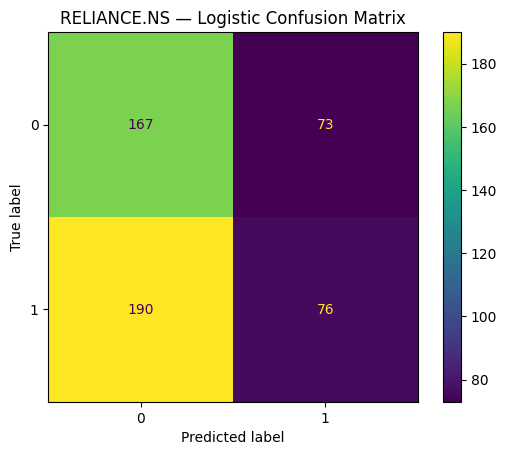

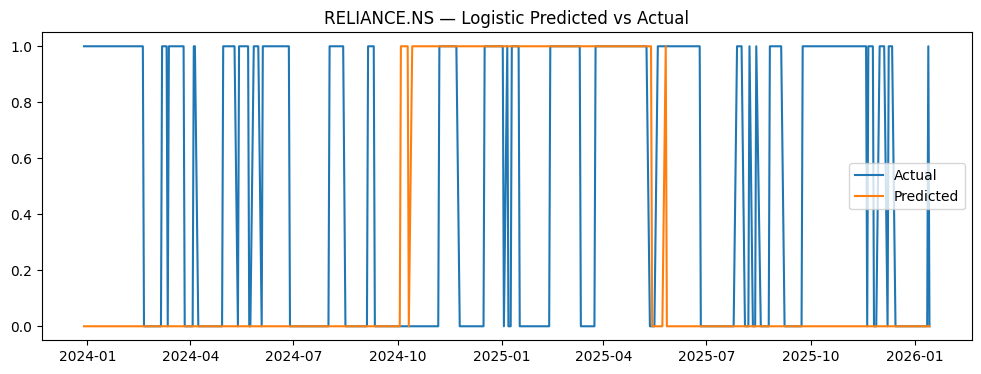

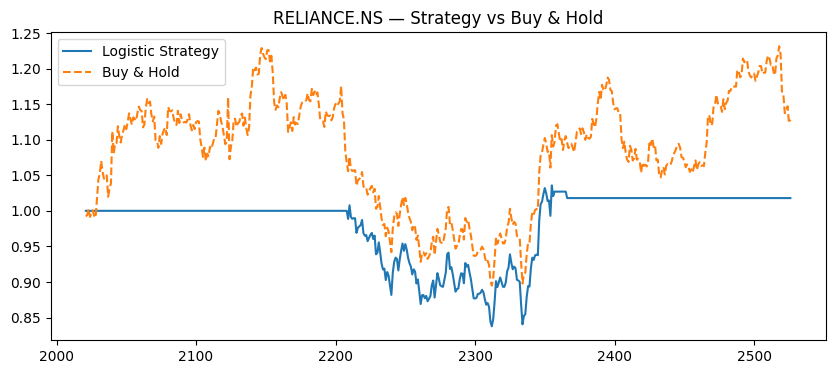


🚀 LOGISTIC REGRESSION — HDFCBANK.NS

📊 Walk-Forward Validation

Fold 1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.76      1.00      0.86       254

    accuracy                           0.76       336
   macro avg       0.38      0.50      0.43       336
weighted avg       0.57      0.76      0.65       336


Fold 2
              precision    recall  f1-score   support

           0       0.74      0.15      0.25       156
           1       0.56      0.96      0.71       180

    accuracy                           0.58       336
   macro avg       0.65      0.55      0.48       336
weighted avg       0.65      0.58      0.49       336


Fold 3
              precision    recall  f1-score   support

           0       0.42      0.36      0.39       160
           1       0.48      0.54      0.51       176

    accuracy                           0.46       336
   macro avg       0.45      0.45      0

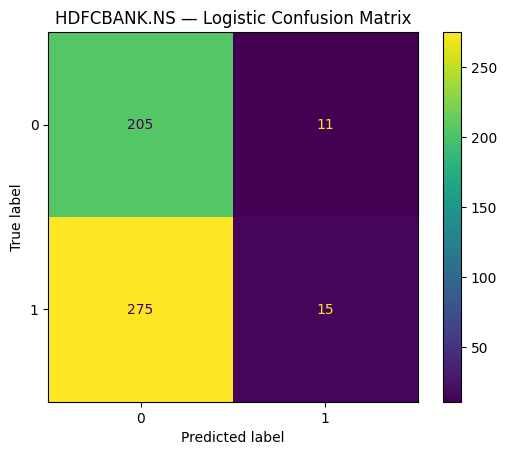

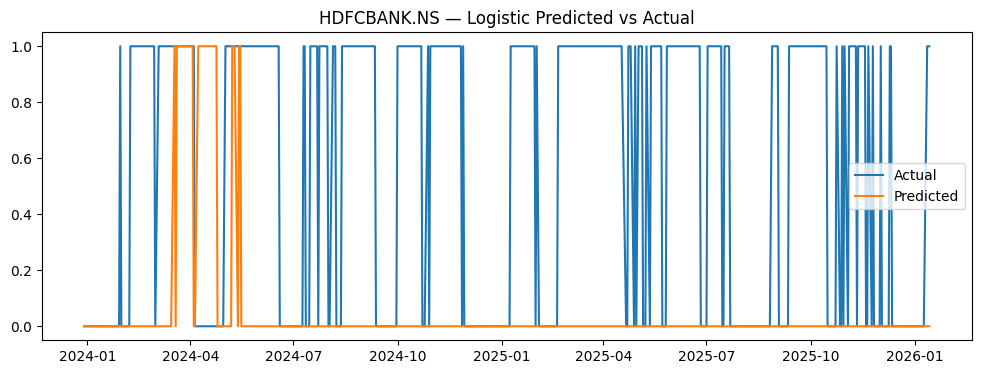

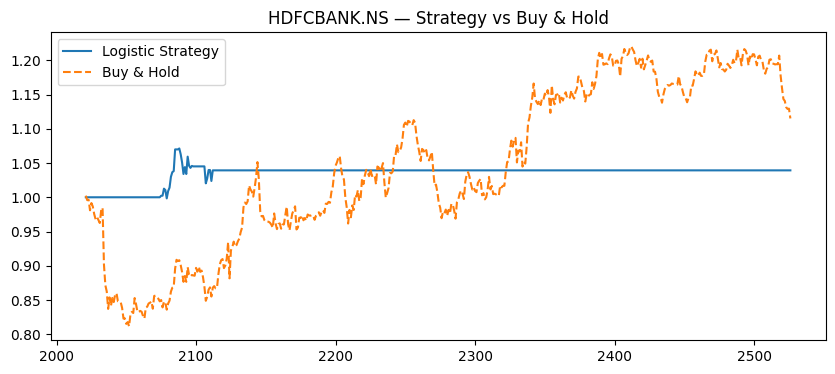


🚀 LOGISTIC REGRESSION — INFY.NS

📊 Walk-Forward Validation

Fold 1
              precision    recall  f1-score   support

           0       0.16      0.17      0.17        98
           1       0.65      0.63      0.64       238

    accuracy                           0.49       336
   macro avg       0.40      0.40      0.40       336
weighted avg       0.51      0.49      0.50       336


Fold 2
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       153
           1       0.00      0.00      0.00       183

    accuracy                           0.46       336
   macro avg       0.23      0.50      0.31       336
weighted avg       0.21      0.46      0.28       336


Fold 3
              precision    recall  f1-score   support

           0       0.32      0.92      0.48        93
           1       0.90      0.26      0.41       243

    accuracy                           0.45       336
   macro avg       0.61      0.59      0.44 

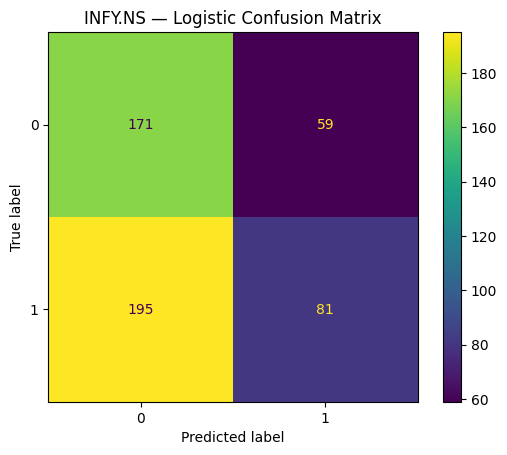

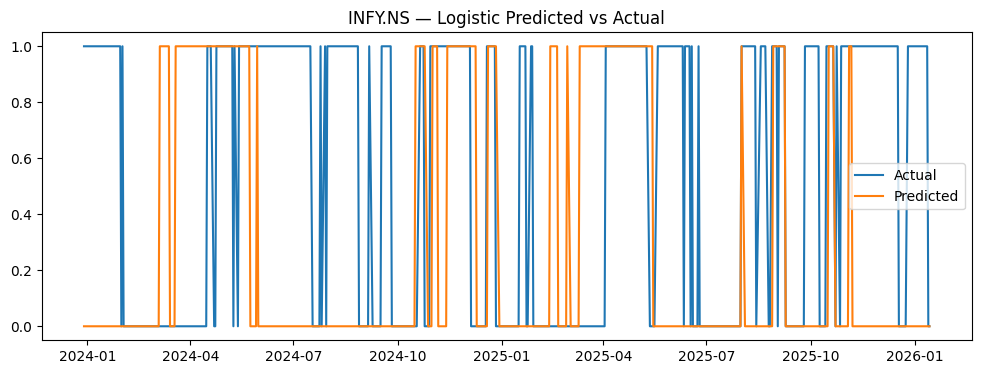

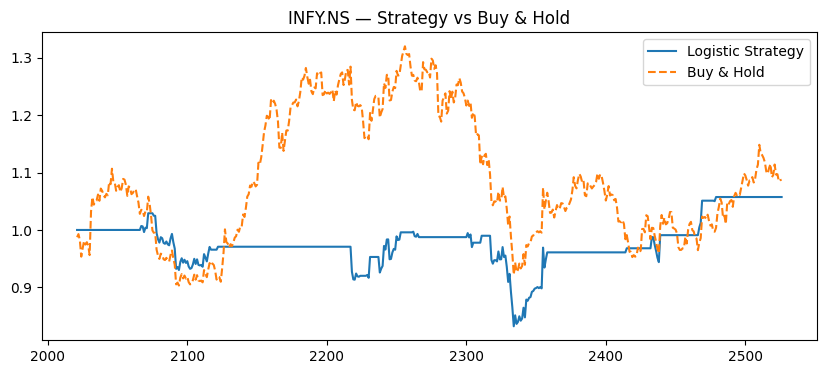

In [ ]:
all_results = {}

for ticker in TICKERS:
    print("\n" + "="*80)
    print(f"LOGISTIC REGRESSION — {ticker}")
    print("="*80)

    df = pd.read_csv(
        f"{PROCESSED_DIR}/{ticker}_features.csv",
        parse_dates=["Date"]
    )

    DROP_COLS = ["Date", "Open", "High", "Low", "Close", "target"]
    X = df.drop(columns=DROP_COLS)
    y = df["target"]

    split_idx = int(len(df) * TRAIN_RATIO)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    df_test = df.iloc[split_idx:].copy()

    
    # WALK-FORWARD CV
    
    print("\n Walk-Forward Validation")

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    cv_metrics = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        )
        model.fit(X_tr_s, y_tr)

        preds = model.predict(X_val_s)

        print(f"\nFold {fold}")
        print(classification_report(y_val, preds))

        cv_metrics.append({
            "ticker": ticker,
            "fold": fold,
            "accuracy": (preds == y_val).mean()
        })

    pd.DataFrame(cv_metrics).to_csv(
        f"{LOGISTIC_RESULTS_DIR}/{ticker}_cv_metrics.csv",
        index=False
    )

    
    # FINAL MODEL
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    final_model = LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    )
    final_model.fit(X_train_s, y_train)

    test_preds = final_model.predict(X_test_s)

    print("\n Final Test Performance")
    print(classification_report(y_test, test_preds))
    
    df_test["prediction"] = test_preds
    df_test["actual"] = y_test.values

    df_bt = backtest_strategy(
        df_test,
        pd.Series(test_preds, index=df_test.index)
    )

    sharpe = sharpe_ratio(df_bt["strategy_ret"].dropna())
    mdd = max_drawdown(df_bt["equity_curve"])
    total_ret = df_bt["equity_curve"].iloc[-1] - 1

    print(f"Sharpe: {sharpe:.3f}")
    print(f"Max Drawdown: {mdd:.3f}")
    print(f"Total Return: {total_ret:.3f}")

    df_bt.to_csv(
        f"{LOGISTIC_RESULTS_DIR}/{ticker}_backtest.csv",
        index=False
    )

    all_results[ticker] = {
        "Sharpe": sharpe,
        "MaxDrawdown": mdd,
        "TotalReturn": total_ret
    }
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_preds)
    plt.title(f"{ticker} — Logistic Confusion Matrix")
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(12,4))
    plt.plot(df_test["Date"], df_test["actual"], label="Actual")
    plt.plot(df_test["Date"], df_test["prediction"], label="Predicted")
    plt.legend()
    plt.title(f"{ticker} — Logistic Predicted vs Actual")
    plt.show()

    # Equity Curve
    plt.figure(figsize=(10,4))
    plt.plot(df_bt["equity_curve"], label="Logistic Strategy")
    plt.plot((1 + df_test["ret_1"]).cumprod(), "--", label="Buy & Hold")
    plt.legend()
    plt.title(f"{ticker} — Strategy vs Buy & Hold")
    plt.show()




# Aggregated Results Summary

    The performance metrics from all tickers are consolidated into a single summary table for easy comparison.

    Converts per-ticker backtest metrics into a unified DataFrame

    Transposes the table so each row represents one ticker

    Saves the summary metrics (Sharpe, Max Drawdown, Total Return) to disk for reproducibility

    data/results_logistic/summary_metrics.csv


This provides a high-level view of model performance across assets.

In [7]:
results_df = pd.DataFrame(all_results).T
results_df.to_csv(
    f"{LOGISTIC_RESULTS_DIR}/summary_metrics.csv"
)
results_df


,Sharpe,MaxDrawdown,TotalReturn
RELIANCE.NS,0.132930,-0.168755,0.017908
HDFCBANK.NS,0.440290,-0.047539,0.039299
INFY.NS,0.265883,-0.191437,0.057406


In [8]:
import pandas as pd

XGB_RESULTS_DIR = "../data/results"
LOGISTIC_RESULTS_DIR = "../data/results_logistic"

TICKERS = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

comparison_rows = []

for ticker in TICKERS:
    # ===============================
    # LOAD XGBOOST METRICS
    # ===============================
    xgb_bt = pd.read_csv(f"{XGB_RESULTS_DIR}/{ticker}_backtest.csv")

    xgb_sharpe = sharpe_ratio(xgb_bt["strategy_ret"].dropna())
    xgb_mdd = max_drawdown(xgb_bt["equity_curve"])
    xgb_total = xgb_bt["equity_curve"].iloc[-1] - 1

    # ===============================
    # LOAD LOGISTIC METRICS
    # ===============================
    log_bt = pd.read_csv(f"{LOGISTIC_RESULTS_DIR}/{ticker}_backtest.csv")

    log_sharpe = sharpe_ratio(log_bt["strategy_ret"].dropna())
    log_mdd = max_drawdown(log_bt["equity_curve"])
    log_total = log_bt["equity_curve"].iloc[-1] - 1

    # ===============================
    # STORE ROWS
    # ===============================
    comparison_rows.append({
        "Ticker": ticker,
        "XGB Sharpe": round(xgb_sharpe, 3),
        "Logistic Sharpe": round(log_sharpe, 3),
        "XGB MaxDD": round(xgb_mdd, 3),
        "Logistic MaxDD": round(log_mdd, 3),
        "XGB Total Return": round(xgb_total, 3),
        "Logistic Total Return": round(log_total, 3),
    })

comparison_df = pd.DataFrame(comparison_rows).set_index("Ticker")

comparison_df




,XGB Sharpe,Logistic Sharpe,XGB MaxDD,Logistic MaxDD,XGB Total Return,Logistic Total Return
Ticker,,,,,,
RELIANCE.NS,1.263,0.133,-0.008,-0.169,0.081,0.018
HDFCBANK.NS,0.303,0.440,-0.100,-0.048,0.052,0.039
INFY.NS,-0.785,0.266,-0.227,-0.191,-0.141,0.057


# Model Performance Comparison (XGBoost vs Logistic)

    For each ticker, the best-performing model is identified based on risk-adjusted return (Sharpe ratio) and absolute profitability (Total Return).

    Best Sharpe Model:
    Selects the model with the higher Sharpe ratio, emphasizing risk-adjusted performance.

    Best Return Model:
    Selects the model with the higher total return, focusing on absolute profit.

    The final comparison is saved for reference and reporting:

        data/model_comparison.csv

    Key Insights

    RELIANCE.NS: XGBoost dominates both risk-adjusted and absolute returns

    HDFCBANK.NS: Logistic Regression offers better risk-adjusted returns, while XGBoost delivers higher total return

    INFY.NS: Logistic Regression outperforms on both Sharpe and total return

In [11]:
comparison_df["Best Sharpe Model"] = comparison_df[
    ["XGB Sharpe", "Logistic Sharpe"]
].idxmax(axis=1)

comparison_df["Best Return Model"] = comparison_df[
    ["XGB Total Return", "Logistic Total Return"]
].idxmax(axis=1)

comparison_df.to_csv("../data/model_comparison.csv")

comparison_df



,XGB Sharpe,Logistic Sharpe,XGB MaxDD,Logistic MaxDD,XGB Total Return,Logistic Total Return,Best Sharpe Model,Best Return Model
Ticker,,,,,,,,
RELIANCE.NS,1.263,0.133,-0.008,-0.169,0.081,0.018,XGB Sharpe,XGB Total Return
HDFCBANK.NS,0.303,0.440,-0.100,-0.048,0.052,0.039,Logistic Sharpe,XGB Total Return
INFY.NS,-0.785,0.266,-0.227,-0.191,-0.141,0.057,Logistic Sharpe,Logistic Total Return
